### Intro to Bayes using PyMC3 

Frequentist statistics are often the basic examples we learn in introductory statisitcs courses.

The philosophy of frequentism is effectively that there is some real truth out in the world about our data or process, and we trying to estimate the true parameters. We can increase our sample sizes, and run some analysis to try and determine what the truth is, and talk about thing like p-values and confidence limits to understand how far off reality we were.

Bayesians have a different intepretation of probability - we update our expectations based on the data, and try and form the most reasonable expectation.

A more obvious difference is the use of priors: In a bayesian framework we are interested in expectations: Expectations are modified by our prior beliefs.

![](https://imgs.xkcd.com/comics/frequentists_vs_bayesians.png)

Most Bayesians would argue that by default humans are Bayesian - no one would assume that the sun has gone nova based on the above evidence. 

We incorporate evidence to change priors - in the case above, probably you would roll more dice, fund another particle detector, and call NASa before concluding that the sun is gone. In a less extreme case we probably hpld a weaker prior, and could be convinced by a few more rolls.

### Bayes Theorem

Let's take an example - We have a test for alcohol screening pilots on duty. We know that if a pilot has been drinking, 95% of the time, the test will be positive. Similarly, if the pilot has not been drinking, 99% of the time the test will be negative. We know that 0.5% of the pilot are drinking (this is our prior).

If we score a pilot as positive on the test, what is the chance that the officer has been drinking?

In [1]:
### Show of hands for 99%, 50-99%, 10-50%, less than 10%

Bayes theorem, named after the Revered Thomas Bayes can be stated as below:

$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$

![](https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg)

In English, $P(A|B)$ mean the probability of drinking (A), given a positive test (B).

$P(A|B)$ is the probability of a positive test, given a that the subject is drinking, $P(A)$ is the probability of drinking (prior).

Let's plugn in our numbers:

In [2]:
puser = 0.005
pnonuser = 1 - puser
puserpos = 0.95
pnonuserpos = 1 - 0.99

prob = (puserpos * puser)/(puserpos*puser + pnonuserpos*pnonuser)
#prob 

Unintuitive right? 

So, we can see that with a strong prior, we cannot say much from a single test. Probably anyone who has taken an undergrad statistics course has seen a similar example - with the pilot changed to a criminal, or a medical test for a rare disease.

Then, Bayes is done for our class, and we move on. This is due to the fact that it is pretty difficult to do more without a lot of math. 

How would we update our prior if we tested 100 people and saw a new ratio of drinkers? What if we retested the same pilot multiple times? These are solvable, but not easily without a lot more detail than most courses will want to give you.

### Probabilistic Programming

Probabilistic programming allows us to get around a lot of the math.

Unlike the initial guess of what probabilistic programming does, it is not about writing code randomly - instead it means that we have probablitity distributions and model components in our programming language, that we can use to build models. 

Let's put the above example into `pymc3` to get a feel for the setup. It's a bit of overkill!

In [3]:
import pymc3 as pm
import numpy as np

###we use a context manager for the model:
with pm.Model() as drunk_pilots:
    #prior
    ###a bernoulli is a single yes/no with a defined p
    drinker = pm.Bernoulli('drinks', 0.005)
    
    #testpos
    #is a function of our drinker variable
    test_pos = drinker * 0.95 + (1-drinker) * 0.01
    
    ##actualtest
    ##here we have the actual 'test'
    ##in this case we observed just 1 positive
    tests = pm.Bernoulli('tests', test_pos, observed=1)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Our model is now defined!

Let's run it:

In [4]:
with drunk_pilots:
    trace = pm.sample(draws=10000)

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [drinks]
100%|██████████| 10500/10500 [00:01<00:00, 6887.82it/s]


In [5]:
trace['drinks'].mean()

0.3234

In [6]:
prob

0.3231292517006801

Not a bad guess! 

But, now imagine we want to update our model - we have been hired by an aircraft company to test 1000 of their pilots. They have a feeling that they might have a problem, so we want to be able to update our prior rate that was previously set at 1.

We can give our prior it's own prior! In this case, let's set it at a mean of 0.005, but with an sd of 0.05 - we allow our parameter to vary a little. I will choose a normal distribution for now - we could use any (or if we really wanted, use the conjugate prior).

We will also do some conversion of the model - a Bernoulli trial repeated N times is a binomial.

In [7]:
# we got 10 positives from 100 pilots
data = np.append(np.ones(20),np.zeros(980))

N = len(data)

with pm.Model() as drunk_pilots:
    #prior for p
    drinksp = pm.Normal('drinksp',0.005, 0.1)
    
    ###a binomial is total number of drunks, with n positives
    drinks = pm.Binomial('drinks', N, drinksp)
    
    #testpos
    #is a function of our drinks variable
    test_pos = drinks/N * 0.95 + (1-drinks/N) * 0.01
    
    ##actualtest
    ##here we have the actual 'test'
    ##in this case we observed just 1 positive
    tests = pm.Binomial('tests', N, test_pos, observed=data.sum())

/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [drinksp]
>Metropolis: [drinks]
 99%|█████████▉| 10385/10500 [00:06<00:00, 1663.77it/s]/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 10500/10500 [00:06<00:00, 1662.64it/s]
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The number of effective samples is smaller than 10% for some parameters.


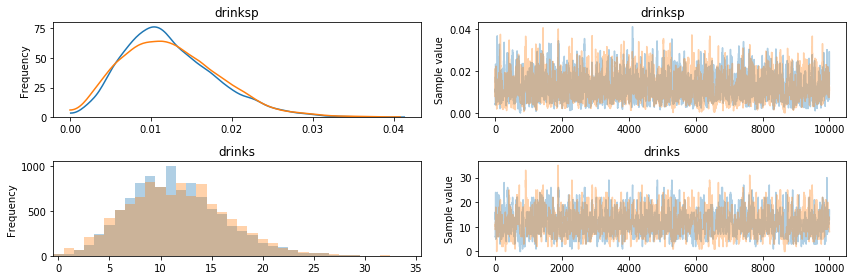

In [8]:
with drunk_pilots:
    trace = pm.sample(draws=10000)
pm.traceplot(trace);

We can see we have substantially updated our prior - to

In [9]:
trace['drinksp'].mean()

0.012461416558532988

and have a total number of drinkers as

In [10]:
trace['drinks'].mean()

11.5388

We have just seen a small pymc3 model - how is it working under the hood?

### PyMC3

[PyMC3](http://docs.pymc.io/) was originally started as a project by Chris Fonnebeck, and was incorporated into numfocus last year (the organisation that umbrellas pyData, as well as numpy, pandas etc). 

It is a package for Bayesian statistical modeling based on MCMC and variational inference. 

Bayesian software has a relatively recent history: WinBugs, Stan, Edward and George as in the same area - in R Stan is the big competitor, and a few people might have memories of typing their own models into WinBugs.

Under the hood PyMC3 has some super cool stuff going on:

As a high level 'gist': when we make a model, we need to calculate the likelihood functions to sample. We then choose some random samples of our parameters, compare to the likelihoods, and add/remove them from the chain.

PyMC3 uses theano to calculate the computational graph of the model, and calculate the gradients - this means that our model is jit compiled into C, and is super quick. Unfortunately theano has reached end of life, so work is currently underway to port the backend to TensorFlow.

We are also using some smart sampling - we use [NUTs](https://arxiv.org/abs/1111.4246), or [Metropolis Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). This is a bit beyond this talk!.

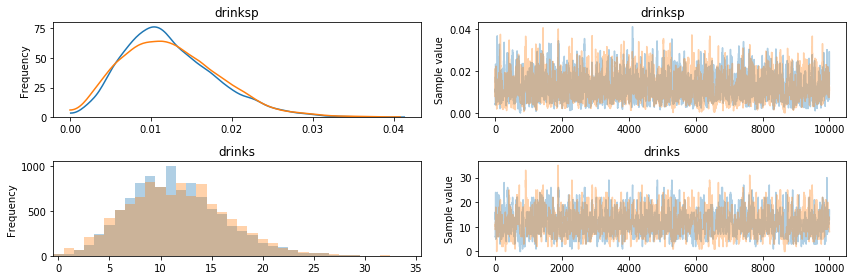

In [11]:
pm.traceplot(trace);

For the purposes of most people, we can decide that as long as we know the way to build a model, and can define the parameters and distributions correctly, the exact math doesn't work. [Eric Ma](https://www.youtube.com/watch?v=p1IB4zWq9C8) has called the 'sample' function the 'Inference Button™', and this is how you can use it.

### A-B testing

Now we have the basics, and an intuition for the workings, we can run more complicated models. A common method is to determine the difference in user response to websites: we know that we have x sales on site A, and y on site B, but how can we compare them? NB, this example is modified from the excellent text, ['Probabilistic-Programming-and-Bayesian-Methods-for-Hackers'](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb), by Cameron Davidson-Pilon.

Let's say we have set up an A/B test on our website:

We know our current website gets 30000 hits per day, and that it seems to work. We will pre-test the website with 5000 of those visitors sent to version 'B', leaving 25000 on 'A'. 

We then want to compare if there is any difference in the sites:

In [12]:
from scipy import stats
np.random.seed(1234)

na = 25000
nb = 5000
p_a_buy = 0.04
p_b_buy = 0.05

data_a = stats.bernoulli.rvs(size = na, p = p_a_buy)
data_b = stats.bernoulli.rvs(size = nb, p = p_b_buy)
print(data_a.sum(), data_b.sum())
print(data_a.mean(), data_b.mean())

1036 245
0.04144 0.049


In frequentist stats, probably we would carry out a Fishers Exact or Chi Squared test - we create a contingency table of the data:

|   | A  | B  | 
|---|---|---|
|bought|1036|245|
|not bought|23964|4755|

And carry out the test:

In [13]:
oddsratio, pvalue = stats.fisher_exact([[1036, 245], [23964, 4755]])
oddsratio, pvalue

(0.8390442807067744, 0.017480017473782593)

So, we can see it is significant, but we don't really have a good idea of exactly what the effect is. What is the range of sales we can expect? How did it change?

Let's try it in pymc3:

In [14]:
with pm.Model() as abmodel:
    ###let's use uniform priors
    ###no idea how sales looks!
    pa = pm.Uniform('pa', 0,1)
    pb = pm.Uniform('pb', 0,1)
    
    ###we can create calculated values
    ###if they depend on others, and are not random
    ###use the deterministic function
    diff = pm.Deterministic('diff', pa - pb)
    
    ###we have two obs, a and b
    obsa = pm.Bernoulli("obsa", pa, observed=data_a)
    obsb = pm.Bernoulli("obsb", pb, observed=data_b)
    trace = pm.sample(20000)
    burned_trace=trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pb_interval__, pa_interval__]
100%|██████████| 20500/20500 [00:28<00:00, 708.58it/s]
The acceptance probability does not match the target. It is 0.8834821391189489, but should be close to 0.8. Try to increase the number of tuning steps.


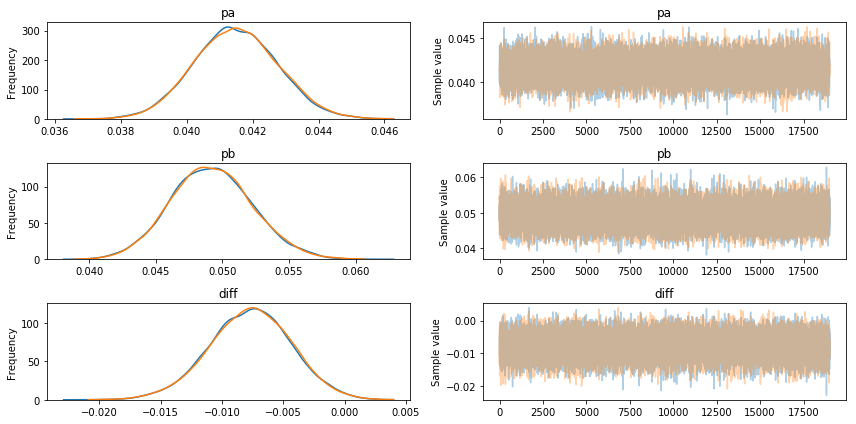

In [15]:
pm.traceplot(burned_trace);

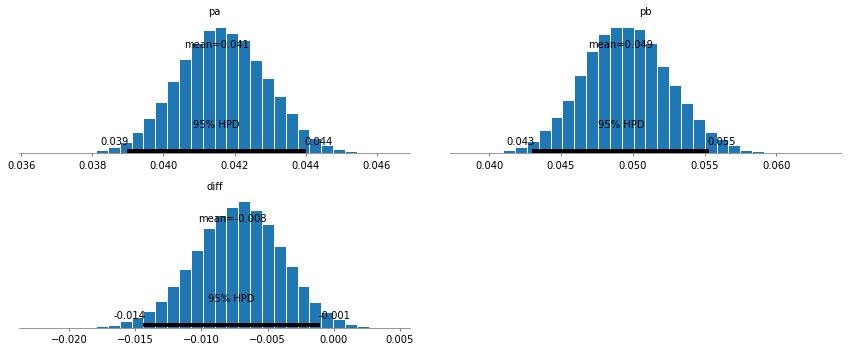

In [16]:
pm.posteriorplot.plot_posterior(burned_trace);

We get a distribution of the diffs. This is really nice - if we want to explore our expected sales, or if our redesign costs a lot more ot run, we can know how much it might be worth.

### More Complicated Models

We can continue on and make our models arbitraily complicated.

For this, let's model my commute (with a bit of exaggeration). Again, this is a modified example from [Colin Carroll](https://colcarroll.github.io/pydata_nyc2017/Probabilistic_Programming_slides.html).

I have several ways of getting to work - and it will depend on various factors which I take, but they will add up to give an overall distribution of my commute time.

I leave my condo, and walk to the closest bixi stand. If there is a bike, I will bike to work, drop off the bixi, and I'm done. If there is no available bixi, I have the choice of taking a streetcar, or walking. Let's put this together into a model:

In [17]:
from theano import tensor as tt

with pm.Model() as commute_time:
    #time to get to bixi
    walk_to_bixi = pm.Normal('walk_to_bixi', 5, 1)
    
    #chance of bixi being available
    bixi_av = pm.Bernoulli('bixi_av', 0.2)
    
    #Decision to take streetcar
    take_streetcar = pm.Bernoulli('take_streetcar', 0.5)
    
    #Streetcar time
    streetcar_time = pm.Normal('streetcar_time', 15, 5)
    
    #Walk time
    walk_time = pm.Normal('walk_time', 30, 5)
    
    #bixi time
    bixi_time = pm.Normal('bixi_time', 7, 2)
    
    ###put it all together
    total_time = pm.Deterministic('total_time',
        walk_to_bixi +\
        #if else!
        tt.switch(bixi_av, bixi_time,\
                tt.switch(take_streetcar,\
                          streetcar_time, walk_time)))
    trace = pm.sample(size = 1000)

/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [bixi_time, walk_time, streetcar_time, walk_to_bixi]
>BinaryGibbsMetropolis: [bixi_av, take_streetcar]
100%|██████████| 1000/1000 [00:01<00:00, 706.78it/s]/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.


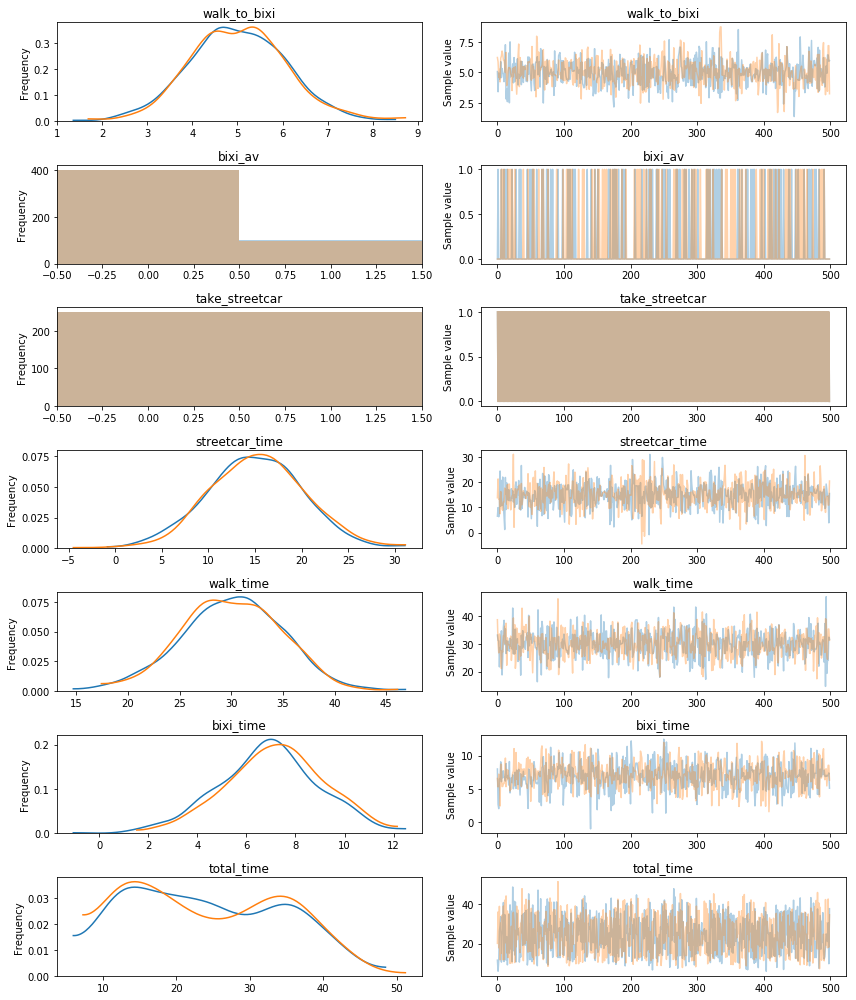

In [18]:
pm.traceplot(trace);

With a model like this, we can now seriously slice and dice the outcomes. What if I know that there is no bixi available?

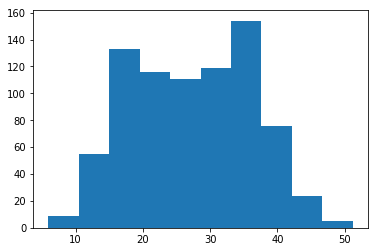

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(trace['total_time'][trace['bixi_av'] == 0]);

How long will I commute if I took the streetcar? 

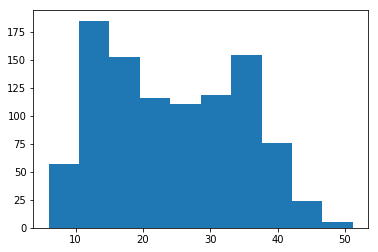

In [20]:
plt.hist(trace['total_time'][trace['streetcar_time'] != 0]);

There are a million other useful things we can do in PyMC3, not limited to the examples here:

* GLMs and hierachical regression
* Gaussian Process Modeling
* ADVI for finding maximum likelihoods
* Time series Analysis
* Deep learning with priors and supports

### Resources

The [pymc docs](http://docs.pymc.io/) are useful, albeit a little technical.

The authours maintain a [binder of useful notebooks](https://hub.mybinder.org/user/pymc-devs-pymc3-72og5tx5/tree//docs/source/notebooks) with interactive notebooks and examples.

Pycon Talks by [Chris Fonnebeck](https://www.youtube.com/watch?v=5TyvJ6jXHYE) and [Eric Ma](https://www.youtube.com/watch?v=p1IB4zWq9C8).

[Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) is a great introduction to Bayes and PyMC3